# Emotion Sentiment Analysis

## Introduction
The purpose of this project is to create a statistical model that can identify the emotional sentiment of a short sentence as accurately as possible. The possible scope of this project is greatly restrained by the dataset that was chosen, as it only includes 6 emotional sentiments for the algorithm to identify. In reality emotional sentiment is very nuanced and there are much more than just 6 emotional sentiments that one may express, but the simplicity of this dataset will make it easier for me to experiment and learn in the course of this project. 

This project is ultimately for my own learning, but it is reasonable that there may be practical application for the model that it created. This model may be effectively used as a step in a pipeline for an automated bot that provides moderation services. It may also be used in the process of gathering a large corpus of text for a different machine learning project by providing a light-weight classifier that will allow a scraper to gather a lot of text from the internet that expresses certain sentiments.

As previously stated, the text samples are divided into 6 categories depending on their emotional sentiment: Anger, Sadness, Love, Joy, Fear, and Surprise. These sentiments are quite generalized, and most other emotions that people express in a typical discourse can be grouped into one of them. For this reason, they are a good representation of a generalized emotional range. The data was retrieved from [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp). The original uploader has already processed and cleaned the data, rendering it into a format that is ready for tokenization and analysis via machine learning. The data has also already been split into training, validation, and test sets of appropriate size, so it will not be necessary to perform any splits before or during the training process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Exploratory Data Analysis

Before we start training any models, I want to explore the data a little bit to see if I can identify any patterns or learn something that will affect how I go about training my models and ultimately analyzing their results. Let's start by loading the separate data files, previewing them, and then combining them back into the original full dataset to get the whole picture of what's going on in it.

In [2]:
# Load the datasets
train_df = pd.read_csv('data/train.txt', sep=";", header=None, names=["Text", "Label"])
test_df = pd.read_csv('data/test.txt', sep=";", header=None, names=["Text", "Label"])
val_df = pd.read_csv('data/val.txt', sep=";", header=None, names=["Text", "Label"])

# Display the first few rows of each dataset to understand their structure
train_df.head(), test_df.head(), val_df.head()

(                                                Text    Label
 0                            i didnt feel humiliated  sadness
 1  i can go from feeling so hopeless to so damned...  sadness
 2   im grabbing a minute to post i feel greedy wrong    anger
 3  i am ever feeling nostalgic about the fireplac...     love
 4                               i am feeling grouchy    anger,
                                                 Text    Label
 0  im feeling rather rotten so im not very ambiti...  sadness
 1          im updating my blog because i feel shitty  sadness
 2  i never make her separate from me because i do...  sadness
 3  i left with my bouquet of red and yellow tulip...      joy
 4    i was feeling a little vain when i did this one  sadness,
                                                 Text    Label
 0  im feeling quite sad and sorry for myself but ...  sadness
 1  i feel like i am still looking at a blank canv...  sadness
 2                     i feel like a faithful servant

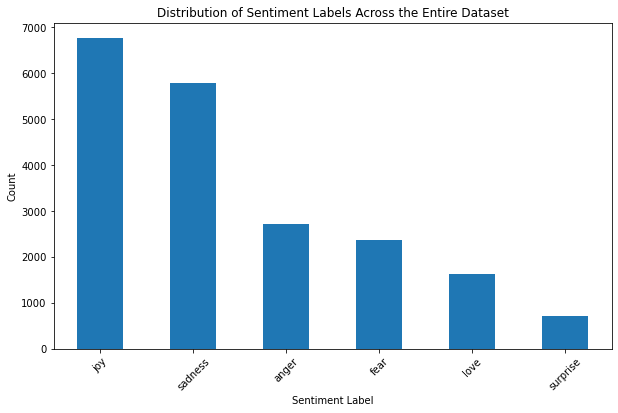

In [3]:
# Combining all datasets to analyze the overall distribution
combined_df = pd.concat([train_df, test_df, val_df])

# Counting the occurrences of each label in the combined dataset
label_distribution = combined_df['Label'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Distribution of Sentiment Labels Across the Entire Dataset')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Across the entire dataset, there is a significant imbalance between the labels. Joy and Sadness each seem to be roughly twice as common as anger and fear, with love and surprise trailing behind them. If we later find that the models are struggling to identify surprise, love, anger, and fear, we may try implementing some sort of class imbalance correction to improve the issue. We can also identify that there are only 6 unique labels in the data, as previously mentioned.

Something else which may affect the results is the length of text samples in the dataset. Let's find the average length and standard deviation of length within each set of the data to ensure they are roughly to same.

In [4]:
from collections import Counter

# Function to calculate the average length and standard deviation of text samples
def calculate_text_statistics(df):
    lengths = df['Text'].str.len()
    avg_length = lengths.mean()
    std_dev_length = lengths.std()
    return avg_length, std_dev_length


# Calculating statistics for each dataset
avg_length_train, std_dev_train = calculate_text_statistics(train_df)
avg_length_test, std_dev_test = calculate_text_statistics(test_df)
avg_length_val, std_dev_val = calculate_text_statistics(val_df)

In [5]:
print("Average Length of training sample:", avg_length_train)
print("Standard deviation of training sample length:", std_dev_train)

Average Length of training sample: 96.8458125
Standard deviation of training sample length: 55.904952812332766


In [6]:
print("Average Length of test sample:", avg_length_test)
print("Standard deviation of test sample length:", std_dev_test)

Average Length of test sample: 96.5865
Standard deviation of test sample length: 55.71599100417033


In [7]:
print("Average Length of valuation sample:", avg_length_val)
print("Standard deviation of valuation sample length:", std_dev_val)

Average Length of valuation sample: 95.3475
Standard deviation of valuation sample length: 54.82375913810559


Looks like everything is in order. The uploader's splitting of the data does not seem to have produced any imbalance between the splits. 

Next, let's look for additional features within the text that may later help our model to identify which category of data a given sample fits into. There are probably at least a few words that are unique to each sentiment, so let's try to programmatically create a list of those words.

In [8]:
# Function to find unique words associated with each label
def find_unique_words(df):
    unique_words = {}
    labels = df['Label'].unique()
    for label in labels:
        words = ' '.join(df[df['Label'] == label]['Text']).split()
        word_counts = Counter(words)
        for other_label in labels:
            if other_label != label:
                other_words = ' '.join(df[df['Label'] == other_label]['Text']).split()
                word_counts -= Counter(other_words)
        unique_words[label] = [word for word, count in word_counts.items() if count > 0]
    return unique_words

In [15]:
# Finding unique words for the combined dataset
unique_words = find_unique_words(combined_df)

This list of words is excessively long - way too long to be useful to us as is. Later on, we may decide to pick just 1-2 unique words to associate with each category and the one-hot encode their presence in the data across all the splits, depending on how well the model performs without this optimization. First, let's visualize how many unique words are present in each label.

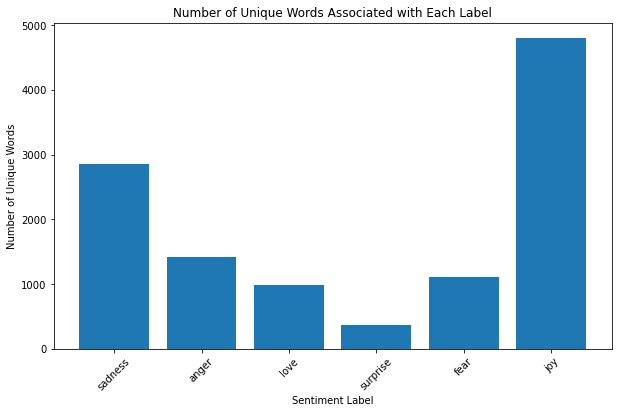

{'sadness': 2861,
 'anger': 1421,
 'love': 990,
 'surprise': 373,
 'fear': 1118,
 'joy': 4798}

In [10]:
# Calculating the number of unique words for each label
unique_word_counts = {label: len(words) for label, words in unique_words.items()}

# Plotting the number of unique words for each label
plt.figure(figsize=(10, 6))
plt.bar(unique_word_counts.keys(), unique_word_counts.values())
plt.title('Number of Unique Words Associated with Each Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Unique Words')
plt.xticks(rotation=45)
plt.show()

unique_word_counts

## Data Cleaning?

This data has come pre-cleaned and prepared for any type of machine learning we may want to do. The only step we have to do is split the dataframes into X and y sets. After this, we will be prepared to create our first model!

In [11]:
# Split the training data
X_train = train_df['Text']
y_train = train_df.drop('Text', axis=1)

# Split the test data
X_test = test_df['Text']
y_test = test_df.drop('Text', axis=1)

# Split the validation data
X_val = val_df['Text']
y_val = val_df.drop('Text', axis=1)

## Tokenization

One of the most important decisions we have to make during this project is what kind of tokenziation to use. The most effective tokenization method depends on which type of model we are creating. Let's start with a simple modeling technique first - we'll use a naive bayes model, which will benefit from using tf-idf tokenization.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Using the nltk list of stopwords to remove stopwords from the data
stopwords_list = stopwords.words('english')

# Instantiate the vectorizer and fit it to the training data/vectorize it. We constrain the vectorizer to 100 max features to ensure
# the training process runs quickly.
tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords_list)
X_train_vectorized = tfidf.fit_transform(X_train)
X_val_vectorized = tfidf.transform(X_val)

In [13]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a MultinomialNB classifier and fit it to the training data
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)

# Evaluate the baseline model's accuracy score using the validation set
baseline_model.score(X_val_vectorized, y_val)

C:\Users\David\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.3645